# Collating Data
This notebook serves to discard unnecessary data from larger Kaggle datasets, and to integrate them into a single dataset that a second notebook can perform training on.

*Commented code may still be present in this notebook in case work needs to be done with that code in the future*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
file_df = pd.read_csv('/kaggle/input/satellite-data-on-australia-fires/modis_2000-2019_Australia.csv')

# Weather for Brisbane and Sydney
weather_bne_df = pd.read_csv('/kaggle/input/bom-weather-observation-data-select-stations/IDCJAC0010_040913_1800_Data.csv')
weather_syd_df = pd.read_csv('/kaggle/input/bom-weather-observation-data-select-stations/IDCJAC0010_066062_1800_Data.csv')

monthly_soi_df = pd.read_csv('/kaggle/input/yicte-2023-southern-oscillation-index/monthly_soi.csv')

In [2]:
# Remove all rows that aren't confident
bushfires_df = file_df.drop(file_df[file_df['confidence'] < 95].index)

# Remove unnecessary columns
bushfires_df = bushfires_df.drop(columns=['satellite', 'instrument', 'confidence', 'version', 'daynight', 'type', 'latitude', 'longitude', 'acq_time'])

bushfires_df

,brightness,scan,track,acq_date,bright_t31,frp
44,358.6,1.8,1.3,2000-11-01,305.5,161.0
45,353.3,1.8,1.3,2000-11-01,306.6,131.2
59,369.7,2.4,1.5,2000-11-01,310.0,368.4
63,353.1,1.3,1.1,2000-11-01,304.5,79.3
64,352.1,2.6,1.6,2000-11-01,314.1,191.6
...,...,...,...,...,...,...
5081153,353.9,1.4,1.2,2019-12-31,291.8,109.8
5081157,322.7,1.3,1.2,2019-12-31,283.5,33.6
5081187,331.7,1.0,1.0,2019-12-31,291.7,30.8
5081191,346.2,1.0,1.0,2019-12-31,293.7,54.1


In [3]:
bushfires_df['acq_date'] = pd.to_datetime(bushfires_df['acq_date']) # Turn date from a string into a datetime object
bushfires_df

,brightness,scan,track,acq_date,bright_t31,frp
44,358.6,1.8,1.3,2000-11-01,305.5,161.0
45,353.3,1.8,1.3,2000-11-01,306.6,131.2
59,369.7,2.4,1.5,2000-11-01,310.0,368.4
63,353.1,1.3,1.1,2000-11-01,304.5,79.3
64,352.1,2.6,1.6,2000-11-01,314.1,191.6
...,...,...,...,...,...,...
5081153,353.9,1.4,1.2,2019-12-31,291.8,109.8
5081157,322.7,1.3,1.2,2019-12-31,283.5,33.6
5081187,331.7,1.0,1.0,2019-12-31,291.7,30.8
5081191,346.2,1.0,1.0,2019-12-31,293.7,54.1


# Grouping data by the day
MODIS satellite data includes a list of pixels that have fire (according to the satellite's detection algorithm). We can group this data to find information about the magnitude and severity of fires in Australia each day.

In [4]:
df = pd.DataFrame()
grouped_bushfire_df = bushfires_df.groupby(by=pd.Grouper(key='acq_date',freq='d'))

In [5]:
# Count the amount of bushfires that are counted per period
df['fires'] = grouped_bushfire_df['acq_date'].count()

# Get other values
df['frp'] = grouped_bushfire_df['frp'].sum() # total frp
df['scan'] = grouped_bushfire_df['scan'].sum() # total scan area
df['brightness'] = grouped_bushfire_df['brightness'].mean() # average temperature of a fire
df = df.reset_index()

df

,acq_date,fires,frp,scan,brightness
0,2000-11-01,104,17572.6,195.4,357.982692
1,2000-11-02,211,45603.4,307.3,351.112322
2,2000-11-03,181,27439.3,325.8,353.117680
3,2000-11-04,239,29887.1,299.7,361.599163
4,2000-11-05,43,7193.7,92.0,347.181395
...,...,...,...,...,...
6995,2019-12-27,448,94309.7,719.4,353.765848
6996,2019-12-28,799,122071.1,1085.8,360.062453
6997,2019-12-29,1425,514664.6,2708.7,359.375298
6998,2019-12-30,4049,800508.7,5553.9,371.445913


# Combine with weather data
In combination with MODIS satellite data, we use temperature data collected from weather observatories in Brisbane and Sydney as extra inputs for a potential model.

The following code matches the dates of the bushfire dataset and the temperature dataset.

In [6]:
def prepare_weather_df(dataframe, code):
    year = dataframe['Year']
    month = dataframe['Month']
    day = dataframe['Day']

    # Create a new column with a datetime YYYY-MM-DD object
    dataframe['date'] = pd.to_datetime(dict(year=year, month=month, day=day))
    dataframe[f'max_t_{code}'] = dataframe['Maximum temperature (Degree C)']
    dataframe = dataframe.drop(columns=['Maximum temperature (Degree C)', 'Bureau of Meteorology station number', 'Product code', 'Year', 'Month', 'Day', 'Days of accumulation of maximum temperature', 'Quality'])
    return dataframe

In [7]:
prepared_weather_syd_df = prepare_weather_df(weather_syd_df, 'syd')
prepared_weather_bne_df = prepare_weather_df(weather_bne_df, 'bne')

In [8]:
combined_df_0 = prepared_weather_syd_df.join(prepared_weather_bne_df.set_index('date'), on='date', how='outer')

combined_df = df.join(combined_df_0.set_index('date'), on='acq_date', how='outer')

combined_df = combined_df.dropna()

df = combined_df

df

,acq_date,fires,frp,scan,brightness,max_t_syd,max_t_bne
0.0,2000-11-01,104.0,17572.6,195.4,357.982692,22.8,27.0
1.0,2000-11-02,211.0,45603.4,307.3,351.112322,22.3,24.0
2.0,2000-11-03,181.0,27439.3,325.8,353.117680,23.8,26.0
3.0,2000-11-04,239.0,29887.1,299.7,361.599163,23.0,28.0
4.0,2000-11-05,43.0,7193.7,92.0,347.181395,21.4,28.0
...,...,...,...,...,...,...,...
6919.0,2019-10-12,211.0,36282.4,312.8,361.617062,20.4,21.3
6920.0,2019-10-13,128.0,23654.4,225.6,357.284375,19.2,25.3
6921.0,2019-10-14,230.0,49021.2,346.0,361.449565,21.9,25.9
6922.0,2019-10-15,137.0,23865.6,232.1,357.659854,24.0,27.2


The following code plots the data we have collected.

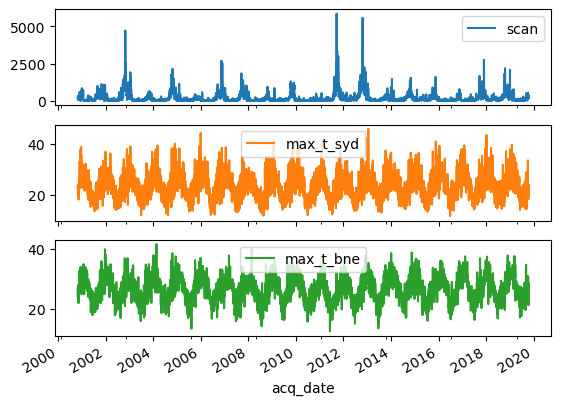

In [9]:
plot_cols = ['scan', 'max_t_syd', 'max_t_bne']
plot_info = combined_df[plot_cols]
plot_info.index = combined_df['acq_date']
_ = plot_info.plot(subplots=True)

# Account for other weather events
El Niño and La Niña weather events are said to have a significant impact on Australian rainfall conditions, and the model should account for this. The Australian Bureau of Meteorology measures these events with the Southern Oscilation Index.

Due to time constraints we haven't factored this into our model (although we have prepared the data for it), but we imagine that the accuracy of the model will be improved with this additional information. Refer to the paper for a list of more data points that could be added to increase the accuracy of the model.

In [10]:
# Save our work
combined_df.to_csv('/kaggle/working/data.csv')